E:\anoconda\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


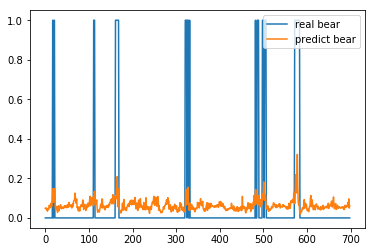

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
data=pd.read_excel('S&P5001.xlsx')
num=12#特征数量

#划分训练集测试集
data1=data.iloc[:,1:]
long1=len(data)
long2=len(data)*3//4
X=data1.iloc[0:long1,0:num]

#标准化X
X=(X - X.min()) / (X.max() - X.min())

y=data1.iloc[0:long1,num:num+1]
X_train, X_test=X.iloc[0:long2],X.iloc[long2:]#列表的切片操作，X.iloc[0:2400，0:7]即为1-2400行，1-7列
y_train, y_test=y.iloc[0:long2],y.iloc[long2:]
X_train,X_test,y_train,y_test=X_train.values,X_test.values,y_train.values,y_test.values

#logit回归 计算出prob of bear market
from sklearn.linear_model import LogisticRegression
logit=LogisticRegression()
logit.fit(X_train, y_train)
prob=pd.DataFrame({'prob': logit.predict_proba(X)[:,1]})
plt.plot(y)
plt.plot(prob)
plt.legend(('real bear', 'predict bear'),loc='upper right')

In [17]:
#由于logit预测出来的prob太低（不到0.5,介于0.1-0.2）所以我们应该改变logit回归的threshold。如何确定threshold？
#我们根据不同的threshold，计算出recall召回率，选召回率最高的threshold

In [18]:
#该函数根据不同的threshold值生成一个recall值
def computerecall(threshold):
    prob['realprob'] = prob.prob.apply(lambda x: 1 if x>threshold else 0)
    bear=data.iloc[:,num+1];
    bearprob=pd.concat([ prob,bear],axis=1);

    right=0;

    noright=0;

    for i in range(0,len(data)-1):
        if bearprob.iloc[i,1]+bearprob.iloc[i,2]==2:#命中的
            right=right+1;
        if bearprob.iloc[i,1]-bearprob.iloc[i,2]==1:#没命中的
            noright=noright+1;    
    
    if noright==0:
        recall=-1;
    else:
        recall=right/(right+noright);
    
    return recall

In [19]:
#这是主程序 循环0.2~0.3之间的100个点，找到最优的threshold和最优的recall
bestrecall=0;
bestthreshold=0;
for i in range(1,100):
    if computerecall(0.1+i*0.001)>bestrecall:
        bestrecall=computerecall(0.1+i*0.001);
        bestthreshold=0.1+i*0.001;
print(bestrecall,bestthreshold);
    

0.9285714285714286 0.14300000000000002


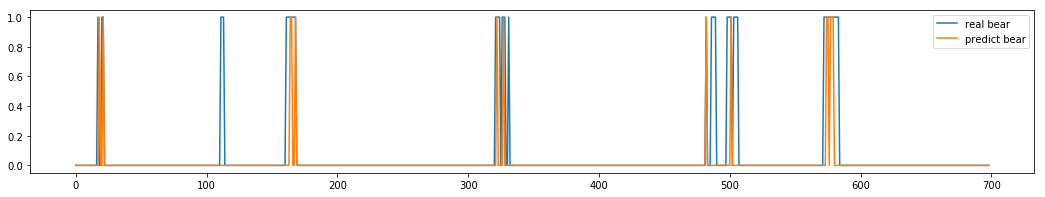

In [20]:
#根据刚刚得到的最优threshold，在threshold以上的为1，以下的为0。得到调整threshold之后的预测值（01）
prob['realprob'] = prob.prob.apply(lambda x: 1 if x>bestthreshold else 0)
bear=data.iloc[:,num+1];
bearprob=pd.concat([ prob,bear],axis=1);
bearprob.iloc[:,2].plot(figsize=(18,3))
bearprob.iloc[:,1].plot(figsize=(18,3))
plt.legend(('real bear', 'predict bear'),loc='upper right')

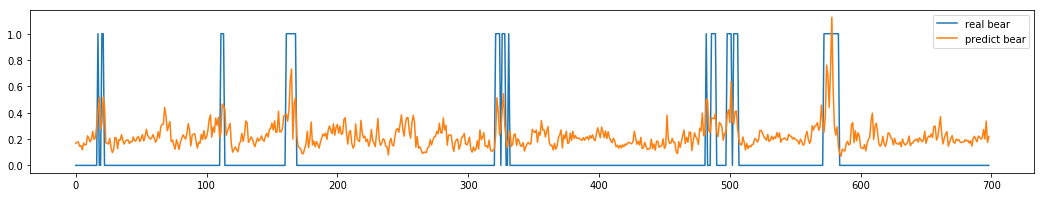

In [21]:
#threshold为0.256，所以此时熊市概率根据threshold做一个放缩
adjustprob=prob.iloc[:,0]/bestthreshold/2
bearprob.iloc[:,2].plot(figsize=(18,3))
adjustprob.plot(figsize=(18,3))
plt.legend(('real bear', 'predict bear'),loc='upper right')